In [52]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import time
import functions
import math

In [5]:
filepath ='/ima/home/hands014//mudac2017/mudac/'
csvfilenames = ['confinement_training.csv', 
                'member_information.csv', 
                'labresults_training.csv', 
                'medical_training.csv', 
                'rx_training.csv',
                'medical_target.csv',
                'rx_target.csv']

with open(filepath+csvfilenames[1]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

members = pd.DataFrame(data)
members.columns = members.iloc[0]
members = members[1:]
members = members.set_index(['PATID']) #makes PATID the row index instead of integers, not sure it's worth it.

with open(filepath+csvfilenames[2]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

labdata = pd.DataFrame(data)
labdata.columns = labdata.iloc[0]
labdata = labdata[1:]

with open(filepath+csvfilenames[3]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

allmedical = pd.DataFrame(data)
allmedical.columns = allmedical.iloc[0]
allmedical = allmedical[1:]

with open(filepath+csvfilenames[4]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

rxdata = pd.DataFrame(data)
rxdata.columns = rxdata.iloc[0]
rxdata = rxdata[1:]

with open(filepath+csvfilenames[5]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

targetallmedical = pd.DataFrame(data)
targetallmedical.columns = targetallmedical.iloc[0]
targetallmedical = targetallmedical[1:]

with open(filepath+csvfilenames[6]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

targetrxdata = pd.DataFrame(data)
targetrxdata.columns = targetrxdata.iloc[0]
targetrxdata = targetrxdata[1:]

In [6]:
medical_wanted = allmedical[('630' >=  allmedical.DIAG1) | (allmedical.DIAG1 >= '67999')]
medical_wanted = medical_wanted[('630' >=  medical_wanted.DIAG2) | (medical_wanted.DIAG2 >= '67999')]

medical_wanted = medical_wanted[('800' >=  medical_wanted.DIAG1) | (medical_wanted.DIAG1 >= '95999')]
medical_wanted = medical_wanted[('800' >=  medical_wanted.DIAG2) | (medical_wanted.DIAG2 >= '95999')]

medical_wanted = medical_wanted[medical_wanted['DIAG1'].str.startswith('E') == False]
medical_wanted = medical_wanted[medical_wanted['DIAG2'].str.startswith('E') == False]

medical_wanted = medical_wanted[(medical_wanted['DIAG1'].str.startswith('V3') == False) & (medical_wanted['DIAG1'].str.startswith('V22') == False) & (medical_wanted['DIAG1'].str.startswith('V23') == False) & (medical_wanted['DIAG1'].str.startswith('V24') == False) & (medical_wanted['DIAG1'].str.startswith('V28') == False) & (medical_wanted['DIAG1'].str.startswith('V91') == False)]
medical_wanted = medical_wanted[(medical_wanted['DIAG2'].str.startswith('V3') == False) & (medical_wanted['DIAG2'].str.startswith('V22') == False) & (medical_wanted['DIAG2'].str.startswith('V23') == False) & (medical_wanted['DIAG2'].str.startswith('V24') == False) & (medical_wanted['DIAG2'].str.startswith('V28') == False) & (medical_wanted['DIAG2'].str.startswith('V91') == False)]



medical_wanted_t = targetallmedical[('630' >=  targetallmedical.DIAG1) | (targetallmedical.DIAG1 >= '67999')]
medical_wanted_t = medical_wanted_t[('630' >=  medical_wanted_t.DIAG2) | (medical_wanted_t.DIAG2 >= '67999')]

medical_wanted_t = medical_wanted_t[('800' >=  medical_wanted_t.DIAG1) | (medical_wanted_t.DIAG1 >= '95999')]
medical_wanted_t = medical_wanted_t[('800' >=  medical_wanted_t.DIAG2) | (medical_wanted_t.DIAG2 >= '95999')]

medical_wanted_t = medical_wanted_t[medical_wanted_t['DIAG1'].str.startswith('E') == False]
medical_wanted_t = medical_wanted_t[medical_wanted_t['DIAG2'].str.startswith('E') == False]

medical_wanted_t = medical_wanted_t[(medical_wanted_t['DIAG1'].str.startswith('V3') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V22') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V23') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V24') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V28') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V91') == False)]
medical_wanted_t = medical_wanted_t[(medical_wanted_t['DIAG2'].str.startswith('V3') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V22') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V23') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V24') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V28') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V91') == False)]

In [ ]:
# Don't run this
targetallmedical.columns = targetallmedical.iloc[0]
targetallmedical = targetallmedical[1:]

medical_wanted_t = targetallmedical[('630' >=  targetallmedical.DIAG1) | (targetallmedical.DIAG1 >= '67999')]
medical_wanted_t = medical_wanted_t[('630' >=  medical_wanted_t.DIAG2) | (medical_wanted_t.DIAG2 >= '67999')]

medical_wanted_t = medical_wanted_t[('800' >=  medical_wanted_t.DIAG1) | (medical_wanted_t.DIAG1 >= '95999')]
medical_wanted_t = medical_wanted_t[('800' >=  medical_wanted_t.DIAG2) | (medical_wanted_t.DIAG2 >= '95999')]

medical_wanted_t = medical_wanted_t[medical_wanted_t['DIAG1'].str.startswith('E') == False]
medical_wanted_t = medical_wanted_t[medical_wanted_t['DIAG2'].str.startswith('E') == False]

medical_wanted_t = medical_wanted_t[(medical_wanted_t['DIAG1'].str.startswith('V3') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V22') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V23') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V24') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V28') == False) & 
                                    (medical_wanted_t['DIAG1'].str.startswith('V91') == False)]
medical_wanted_t = medical_wanted_t[(medical_wanted_t['DIAG2'].str.startswith('V3') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V22') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V23') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V24') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V28') == False) & 
                                    (medical_wanted_t['DIAG2'].str.startswith('V91') == False)]
del(targetallmedical)

In [7]:
medical_wanted.to_csv('trainingmedicalwanted.csv')
medical_wanted_t.to_csv('targetmedicalwanted.csv')

In [8]:
medical_wanted_t.to_csv('targetmedicalwanted.csv')
medical_wanted_t['STD_COST']=medical_wanted_t['STD_COST'].apply(pd.to_numeric) #change entries to numbers

In [9]:
medical_wanted['STD_COST']=medical_wanted['STD_COST'].apply(pd.to_numeric) #change entries to numbers
rxdata.loc[rxdata['STD_COST']=='None', 'STD_COST']=0 #change all nones to zeros
rxdata['STD_COST']=rxdata['STD_COST'].apply(pd.to_numeric) #change all entries to numbers
members['year_of_birth']=members['year_of_birth'].apply(pd.to_numeric)
rxdata['DAYS_FROM_DIAG'] = rxdata['DAYS_FROM_DIAG'].apply(pd.to_numeric)
medical_wanted['DAYS_FROM_DIAG'] = medical_wanted['DAYS_FROM_DIAG'].apply(pd.to_numeric)

medical_wanted_t['STD_COST']=medical_wanted_t['STD_COST'].apply(pd.to_numeric) #change entries to numbers
targetrxdata.loc[targetrxdata['STD_COST']=='None', 'STD_COST']=0 #change all nones to zeros
targetrxdata['STD_COST']=targetrxdata['STD_COST'].apply(pd.to_numeric) #change all entries to numbers
targetrxdata['DAYS_FROM_DIAG'] = targetrxdata['DAYS_FROM_DIAG'].apply(pd.to_numeric)
medical_wanted_t['DAYS_FROM_DIAG'] = medical_wanted_t['DAYS_FROM_DIAG'].apply(pd.to_numeric)

In [10]:
with open(filepath+csvfilenames[6]) as datafile:
    filecontents = csv.reader(datafile, delimiter = ",")
    data = list(filecontents)

targetrxdata = pd.DataFrame(data)
targetrxdata.columns = targetrxdata.iloc[0]
targetrxdata = targetrxdata[1:]

targetrxdata.loc[targetrxdata['STD_COST']=='None', 'STD_COST']=0 #change all nones to zeros
targetrxdata['STD_COST']=targetrxdata['STD_COST'].apply(pd.to_numeric) #change all entries to numbers
targetrxdata['DAYS_FROM_DIAG'] = targetrxdata['DAYS_FROM_DIAG'].apply(pd.to_numeric)

In [11]:
#add training data
members['totalcost'] = 0.0
members['rxcost'] = 0.0
members['medicalcost'] = 0.0

dummy = rxdata.groupby('PATID')['STD_COST'].sum()

for k in range(len(dummy)):
    members.at[dummy.index[k],'totalcost'] += dummy.iat[k]
    members.at[dummy.index[k], 'rxcost'] = dummy.iat[k]
    
dummy = medical_wanted.groupby('PATID')['STD_COST'].sum()

for k in range(len(dummy)):
    members.at[dummy.index[k], 'totalcost'] += dummy.iat[k]
    members.at[dummy.index[k], 'medicalcost'] = dummy.iat[k]
    

#add target data
members['targetcost'] = 0.0 
members['targetrxcost'] = 0.0
members['targetmedicalcost'] = 0.0

dummy = targetrxdata.groupby('PATID')['STD_COST'].sum()


for k in range(len(dummy)):
    members.at[dummy.index[k],'targetcost'] += dummy.iat[k]
    members.at[dummy.index[k], 'targetrxcost'] = dummy.iat[k]

    
dummy = medical_wanted_t.groupby('PATID')['STD_COST'].sum()


for k in range(len(dummy)):
    members.at[dummy.index[k], 'targetcost'] += dummy.iat[k]
    members.at[dummy.index[k], 'targetmedicalcost'] = dummy.iat[k]

In [12]:
#all potentially completely useless
dummy = rxdata.groupby('PATID')['DAYS_FROM_DIAG'].min()
for k in range(len(dummy)):
    members.at[dummy.index[k], 'minrxday'] = dummy.iat[k]
dummy = rxdata.groupby('PATID')['DAYS_FROM_DIAG'].max()
for k in range(len(dummy)):
    members.at[dummy.index[k], 'maxrxday'] = dummy.iat[k]
dummy = medical_wanted.groupby('PATID')['DAYS_FROM_DIAG'].min()
for k in range(len(dummy)):
    members.at[dummy.index[k], 'minmedicalday'] = dummy.iat[k]
dummy = medical_wanted.groupby('PATID')['DAYS_FROM_DIAG'].max()
for k in range(len(dummy)):
    members.at[dummy.index[k], 'maxmedicalday'] = dummy.iat[k]

In [ ]:
#The next several blocks add counters to the member dataframe for the number of visits to different types of facilities

In [13]:
#emergency=['23','24', '21', '41', '20', '42']
medical_wanted_emergency = medical_wanted[(medical_wanted['POS'] =='23') | 
                                          (medical_wanted['POS'] =='24') | 
                                          (medical_wanted['POS'] =='21') |
                                          (medical_wanted['POS'] =='41') |
                                          (medical_wanted['POS'] =='20') |
                                          (medical_wanted['POS'] =='42') ]
members['emervisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_emergency.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'emervisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

16.981734


In [14]:
#psychiatric=['53', '55', '51', '52', '57'] # 51 is inpatient faciliity, 55 is res. sub. abuse
medical_wanted_psych = medical_wanted[(medical_wanted['POS'] =='53') | 
                                          #(medical_wanted['POS'] =='55') |
                                          (medical_wanted['POS'] =='52') |
                                          (medical_wanted['POS'] =='57')]
members['psychvisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_psych.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'psychvisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

0.390206


In [15]:
#regular=['11', '01', '81','22', '60', '49', '71', '62', '17', '50', '61', '03']
medical_wanted_office = medical_wanted[(medical_wanted['POS'] =='11') | 
                                          (medical_wanted['POS'] =='01') | 
                                          (medical_wanted['POS'] =='81') |
                                          (medical_wanted['POS'] =='22') |
                                          (medical_wanted['POS'] =='60') |
                                      (medical_wanted['POS'] =='49') | 
                                          (medical_wanted['POS'] =='71') |
                                          (medical_wanted['POS'] =='62') |
                                          (medical_wanted['POS'] =='17') |
                                      (medical_wanted['POS'] =='50') | 
                                          (medical_wanted['POS'] =='61') |
                                          (medical_wanted['POS'] =='03') ]
members['officevisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_office.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'officevisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

48.456562


In [16]:
#elderly=['13', '31', '32', '33']
medical_wanted_elderly = medical_wanted[(medical_wanted['POS'] =='13') | 
                                          (medical_wanted['POS'] =='31') | 
                                          (medical_wanted['POS'] =='32') |
                                          (medical_wanted['POS'] =='33') ]
members['elderlyvisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_elderly.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'elderlyvisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

0.651733


In [17]:
#home=['12', '14', '15']
medical_wanted_home = medical_wanted[(medical_wanted['POS'] =='12') | 
                                          (medical_wanted['POS'] =='14') | 
                                          (medical_wanted['POS'] =='15')]
members['homevisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_home.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'homevisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

3.332691


In [18]:
#dialysis=['65']
medical_wanted_dialysis = medical_wanted[(medical_wanted['POS'] =='65')]
members['dialysisvisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_dialysis.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'dialysisvisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

0.272208


In [19]:
#hospice=['34']
medical_wanted_hospice = medical_wanted[(medical_wanted['POS'] =='34')]
members['hospicevisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_hospice.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'hospicevisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

0.577105


In [20]:
#unknown=['99', 'None']
medical_wanted_unknown = medical_wanted[(medical_wanted['POS'] =='99')|
                                        (medical_wanted['POS'] == 'None')]
members['unknownvisits']=0
patids = list(members.index)
tick = time.clock()
patidgroups = medical_wanted_unknown.groupby('PATID')
for k in patids:
    try:
        members.loc[k, 'unknownvisits'] = len(patidgroups.get_group(k).groupby('DAYS_FROM_DIAG'))
    except KeyError:
        pass
tock = time.clock()
print tock-tick

11.620863


In [21]:
members.head(n=3)

,gender,year_of_birth,STATE,totalcost,rxcost,medicalcost,targetcost,targetrxcost,targetmedicalcost,minrxday,...,minmedicalday,maxmedicalday,emervisits,psychvisits,officevisits,elderlyvisits,homevisits,dialysisvisits,hospicevisits,unknownvisits
PATID,,,,,,,,,,,,,,,,,,,,,
33004375180.0,F,1990,OH,1766.56,1046.20,720.36,0.00,0.00,0.00,0.0,...,0.0,540.0,0,0,6,0,0,0,0,0
33004540916.0,F,1985,OH,21923.66,238.82,21684.84,3464.08,14.93,3449.15,0.0,...,-2.0,633.0,0,0,21,0,0,0,0,0
33004570387.0,F,1977,FL,10846.42,622.90,10223.52,1014.95,193.67,821.28,-63.0,...,101.0,827.0,5,0,15,0,0,0,0,0


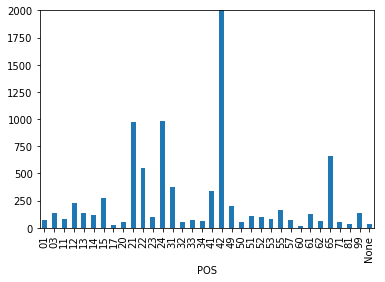

In [22]:
#Plot average cost for all POS codes
location_series = medical_wanted.groupby('POS')['STD_COST'].mean()

location_series.plot.bar()
plt.ylim([0,2000])
plt.show()

#42-Ambulance
#21- Inpatient Hospital
#22- Outpatient Hospital
#24- Ambulatory Surgical Center
#31- Skilled Nursing
#65- End stage renal disease facility

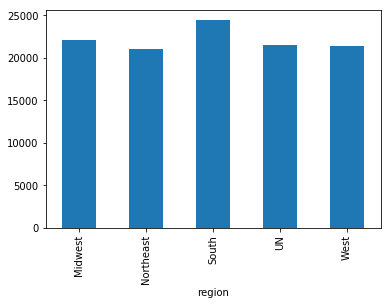

In [23]:
# Add new column for region (should find a way to avoid this with groupby, but can't currently)
members['region'] = members.apply(lambda row: functions.US_region(row), axis=1)

region_series = members.groupby('region')['totalcost'].mean()

region_series.plot.bar()
plt.show()

In [24]:
members.to_csv('members.csv')


In [25]:
# A collection of plots:
#Note: in this situation, we're looking for people who cost around 12k and more:
members.sort_values('targetcost', ascending = 0).iloc[6000]

0
gender                     M
year_of_birth           1970
STATE                     AL
totalcost            19407.8
rxcost               8142.77
medicalcost            11265
targetcost           12375.5
targetrxcost            1120
targetmedicalcost    11255.5
minrxday                -242
maxrxday                 838
minmedicalday           -175
maxmedicalday            813
emervisits                 1
psychvisits                0
officevisits              28
elderlyvisits              0
homevisits                 0
dialysisvisits             0
hospicevisits              0
unknownvisits              0
region                 South
Name: 33048994973.0, dtype: object

In [26]:
# Also note we're looking for a little more than the upper 15% of costs:
series = members['targetcost']
series.quantile([.15, .3, .5, .7, .85, .9 , .95, 1])

0.15        433.148
0.30       1070.770
0.50       2462.720
0.70       5530.904
0.85      12683.098
0.90      18864.000
0.95      33316.190
1.00    1287371.290
Name: targetcost, dtype: float64

In [27]:
members.head(n=3)

,gender,year_of_birth,STATE,totalcost,rxcost,medicalcost,targetcost,targetrxcost,targetmedicalcost,minrxday,...,maxmedicalday,emervisits,psychvisits,officevisits,elderlyvisits,homevisits,dialysisvisits,hospicevisits,unknownvisits,region
PATID,,,,,,,,,,,,,,,,,,,,,
33004375180.0,F,1990,OH,1766.56,1046.20,720.36,0.00,0.00,0.00,0.0,...,540.0,0,0,6,0,0,0,0,0,Midwest
33004540916.0,F,1985,OH,21923.66,238.82,21684.84,3464.08,14.93,3449.15,0.0,...,633.0,0,0,21,0,0,0,0,0,Midwest
33004570387.0,F,1977,FL,10846.42,622.90,10223.52,1014.95,193.67,821.28,-63.0,...,827.0,5,0,15,0,0,0,0,0,South


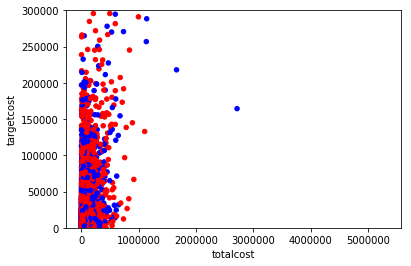

In [31]:

colors = {'F': 'red', 'M': 'blue', 'U': 'green'}
members.plot.scatter(x ='totalcost', y = 'targetcost', c = members['gender'].apply(lambda x: colors[x]))
plt.ylim(0, 300000) #not the actual upper limit, ignoring ncdude
#plt.xlim(0, 3000000)
plt.show()

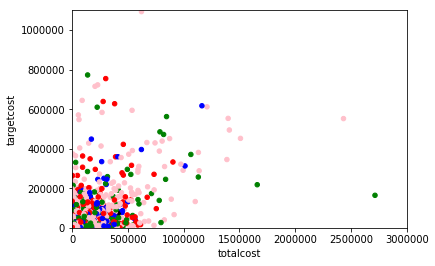

In [29]:
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
members.plot.scatter(x ='totalcost', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 1100000) #not the actual upper limit, ignoring ncdude
plt.xlim(000000, 3000000)
plt.show()
#it appears we can safely exclude people who cost more than 1000000 to begin with.
#Err, include.

In [32]:
submembers = members[members['totalcost']<1000000]

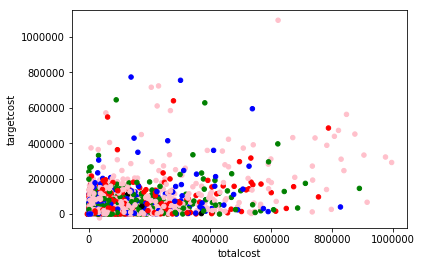

In [33]:
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='totalcost', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
#plt.ylim(0, 300000) #not the actual upper limit, ignoring ncdude
#plt.xlim(0, 3000000)
plt.show()

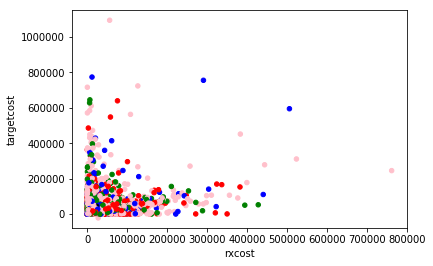

In [34]:
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='rxcost', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.show()

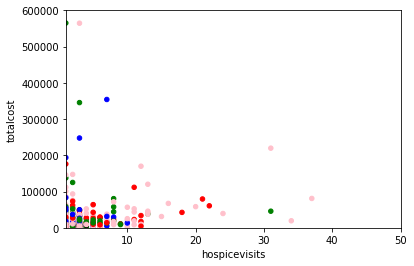

In [35]:
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='hospicevisits', y = 'totalcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 600000) #actually upper limit for this subpopulation
plt.xlim(1, 50) #ignore the 0s
plt.show()

In [36]:
submembers = submembers[submembers['hospicevisits']<15]

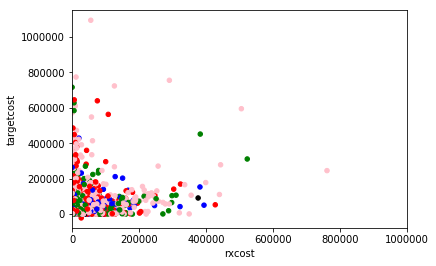

In [37]:
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='rxcost', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
#plt.ylim(0, 100000) #not the actual upper limit
plt.xlim(0,1000000)
plt.show()

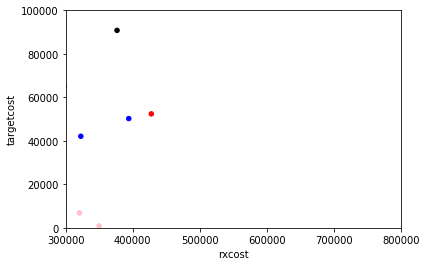

In [38]:
#can safely remove people who spent more than 400000 on prescriptions 
#(but what's going on with the people who went from 300000 to 0???)
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='rxcost', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 100000) # not upper limit for this subpopulation
plt.xlim(300000, 800000) #ignore the 0s
plt.show()

In [39]:
submembers = submembers[submembers['rxcost']<400000]

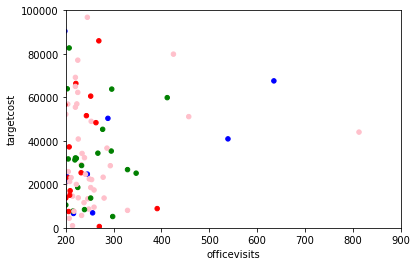

In [40]:
#there's a point at which high numbers of office visits imply something
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='officevisits', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 100000) # not upper limit for this subpopulation
plt.xlim(200, 900) #just compressing a little
plt.show()

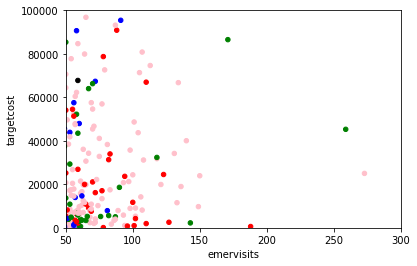

In [41]:
#not so much with high numbers of emergency room visits
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='emervisits', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 100000) # not upper limit for this subpopulation
plt.xlim(50, 300) #just compressing a little
plt.show()

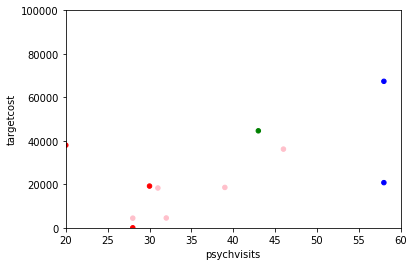

In [42]:
#maybe with psychiatric though
colors = {'Midwest':'red', 'Northeast': 'blue', 'South':'pink', 'UN':'black', 'West':'green'}
submembers.plot.scatter(x ='psychvisits', y = 'targetcost', c = members['region'].apply(lambda x: colors[x]))
plt.ylim(0, 100000) # not upper limit for this subpopulation
plt.xlim(20, 60) #just compressing a little
plt.show()

In [43]:
rxdata.head(n=3)

,PATID,CLMID,AHFSCLSS,DAYS_SUP,QUANTITY,STD_COST,DAYS_FROM_DIAG
1,33051763235.0,1601702440,08140800,2,2.000,1.42,-115
2,33051763235.0,1601702325,08309200,7,14.000,6.06,-115
3,33051763235.0,1470992483,12200400,30,90.000,7.54,-169


In [ ]:
#The next series of cells creates bins for the rx data

In [46]:
#Create 5-day bins and bin labels. I think this puts bin 0 at bin 0,5
print rxdata.DAYS_FROM_DIAG.max() #Find max days from diagnosis
print rxdata.DAYS_FROM_DIAG.min() #Find minimum days before diagnosis
min_day = rxdata.DAYS_FROM_DIAG.min()
max_day = rxdata.DAYS_FROM_DIAG.max()
#Compute the number of bins at some point, didn't automate this
rxdata['fivedaybin'] = pd.cut(rxdata['DAYS_FROM_DIAG'], range(-730, 1100, 5), right=False) #bin by 5 days rounding on the outside to nice numbers
r5=range(-730,1100+5,5) #define bin edges
binlabel5=range(-147,219) #number of negative bins, number of positive bins. Remembering how range works means it should put bin 0 in the correct spot
#categories = pd.cut(rxdata['DAYS_FROM_DIAG'], r, labels=binlabel) #run this if you want to see the bin labels
#print categories
rxdata['fivedaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r5, labels=binlabel5)
#print rxdata.head(n=3)

1095
-727


In [47]:
#Create 7-day bins and bin labels.
rxdata['sevendaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],range(-728,1099,7),right=False) #create the bins
numbins = (728+1099)/7 #automate endpoint search? Probably not worth it
numneg = -728/7
numpos=1099/7
print numneg
print numpos
r7=range(-728,1099+7,7)
binlabel7=range(numneg,numpos)
rxdata['sevendaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r7, labels=binlabel7)
#print rxdata.head(n=3)

-104
157


In [48]:
#Create 10-day bins and bin labels.
rxdata['tendaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],range(-730,1100,10),right=False) #create the bins
numbins = (730+1100)/10 #automate endpoint search? Probably not worth it
numneg = -730/10
numpos=1100/10
print numneg
print numpos
r10=range(-730,1100+10,10)
binlabel10=range(numneg,numpos)
rxdata['tendaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r10, labels=binlabel10)
#print rxdata.head(n=3)

-73
110


In [50]:
#Create 20-day bins and bin labels.
rxdata['twentydaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],range(-740,1100,20),right=False) #create the bins
numbins = (740+1100)/20 #automate endpoint search? Probably not worth it
numneg = -740/20
numpos=1100/20
print numneg
print numpos
r20=range(-740,1100+20,20)
binlabel20=range(numneg,numpos)
rxdata['twentydaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r20, labels=binlabel20)
#print rxdata.head(n=3)

-37
55


In [54]:
#Create 30-day bins and bin labels.
binsize = 30
numbins = int(math.ceil(-min_day/binsize) + math.ceil(max_day/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day/binsize))
numpos = int(math.ceil(max_day/binsize))
print numneg
print numpos
r30=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel30=range(numneg,numpos)
rxdata['thirtydaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],r30,right=False) #create the bins
rxdata['thirtydaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r30, labels=binlabel30)
#print rxdata.head(n=3)

-25
36


In [55]:
#Create 60-day bins and bin labels.
binsize = 60
numbins = int(math.ceil(-min_day/binsize) + math.ceil(max_day/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day/binsize))
numpos = int(math.ceil(max_day/binsize))
print numneg
print numpos
r30=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel30=range(numneg,numpos)
rxdata['sixtydaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],r30,right=False) #create the bins
rxdata['sixtydaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r30, labels=binlabel30)
#print rxdata.head(n=3)

-13
18


In [56]:
#Create 120-day bins and bin labels.
binsize = 120
numbins = int(math.ceil(-min_day/binsize) + math.ceil(max_day/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day/binsize))
numpos = int(math.ceil(max_day/binsize))
print numneg
print numpos
r30=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel30=range(numneg,numpos)
rxdata['onetwentydaybin']=pd.cut(rxdata['DAYS_FROM_DIAG'],r30,right=False) #create the bins
rxdata['onetwentydaybin_id'] = pd.cut(rxdata['DAYS_FROM_DIAG'], r30, labels=binlabel30)
#print rxdata.head(n=3)

-7
9


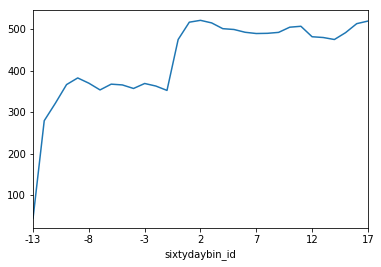

In [58]:
temp = rxdata.groupby(['PATID', 'sixtydaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['sixtydaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [70]:
#the next series of cells creates bins for the medical_wanted data

In [61]:
min_day_med = medical_wanted.DAYS_FROM_DIAG.min()
max_day_med = medical_wanted.DAYS_FROM_DIAG.max()
print min_day_med
print max_day_med

-726
1095


In [63]:
#Create 5-day bins and bin labels.
binsize = 5
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['fivedaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['fivedaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-146
219


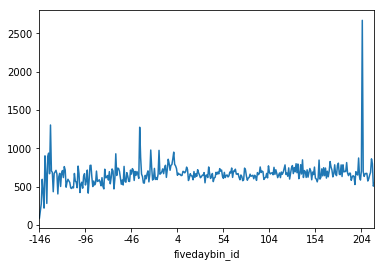

In [72]:
temp = medical_wanted.groupby(['PATID', 'fivedaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['fivedaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [64]:
#Create 7-day bins and bin labels.
binsize = 7
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['sevendaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['sevendaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-104
156


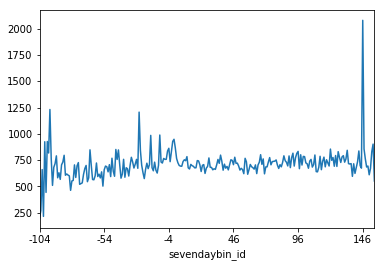

In [73]:
temp = medical_wanted.groupby(['PATID', 'sevendaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['sevendaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [65]:
#Create 10-day bins and bin labels.
binsize = 10
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['tendaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['tendaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-73
109


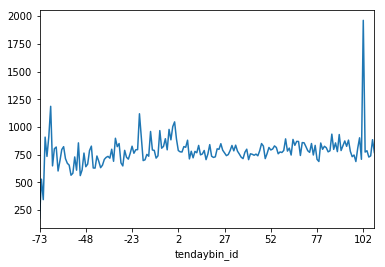

In [74]:
temp = medical_wanted.groupby(['PATID', 'tendaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['tendaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [66]:
#Create 20-day bins and bin labels.
binsize = 20
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['twentydaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['twentydaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-37
54


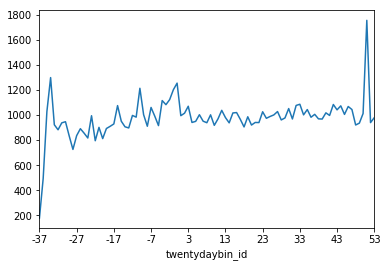

In [75]:
temp = medical_wanted.groupby(['PATID', 'twentydaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['twentydaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [67]:
#Create 30-day bins and bin labels.
binsize = 30
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['thirtydaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['thirtydaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-25
36


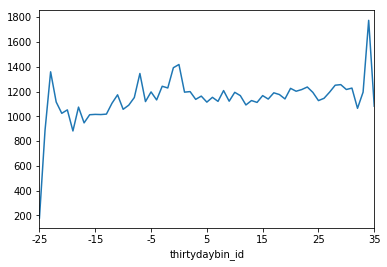

In [76]:
temp = medical_wanted.groupby(['PATID', 'thirtydaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['thirtydaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [68]:
#Create 60-day bins and bin labels.
binsize = 60
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['sixtydaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['sixtydaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-13
18


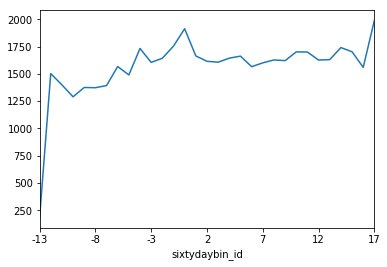

In [77]:
temp = medical_wanted.groupby(['PATID', 'sixtydaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['sixtydaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [69]:
#Create 120-day bins and bin labels.
binsize = 120
numbins = int(math.ceil(-min_day_med/binsize) + math.ceil(max_day_med/binsize)) #automate endpoint search? Probably not worth it
numneg = int(math.ceil(min_day_med/binsize))
numpos = int(math.ceil(max_day_med/binsize))
print numneg
print numpos
r=range(numneg*binsize,(numpos+1)*binsize,binsize)
binlabel=range(numneg,numpos)
medical_wanted['onetwentydaybin']=pd.cut(medical_wanted['DAYS_FROM_DIAG'],r,right=False) #create the bins
medical_wanted['onetwentydaybin_id'] = pd.cut(medical_wanted['DAYS_FROM_DIAG'], r, labels=binlabel)
#print medical_wanted.head(n=3)

-7
9


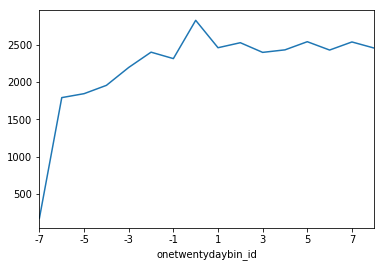

In [78]:
temp = medical_wanted.groupby(['PATID', 'onetwentydaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp.groupby(['onetwentydaybin_id'])['bin_cost'].mean().plot()
plt.show()

In [101]:
#try to find out what's going on with spike
temp2=medical_wanted.groupby('fivedaybin_id')['STD_COST'].sum()
temp2=temp2.sort_values(ascending=False)
#print temp2

#Bin label 205 is giving the crazy spike

In [103]:
temp = medical_wanted.groupby(['PATID', 'fivedaybin_id'])['STD_COST'].sum().reset_index(name='bin_cost')

temp2=temp.groupby(['fivedaybin_id'])['bin_cost'].mean()

temp2=temp2.sort_values(ascending=False)

print temp.head(n=3)
print temp2

           PATID fivedaybin_id  bin_cost
0  33003282832.0            -1    341.62
1  33003282832.0             1   1267.88
2  33003282832.0             2    118.90
fivedaybin_id
 205    2670.845431
-134    1305.765476
-37     1276.719703
-25      979.394193
-16      974.894587
 0       951.945611
-136     938.979381
-63      930.331995
-140     903.461212
-137     896.334951
-36      886.100011
 201     875.307143
 215     864.396365
-1       864.209544
-6       859.056678
 140     851.252873
 158     848.355951
 170     829.276816
 188     815.714490
 179     807.907570
-5       802.949567
 133     801.033908
 216     799.794883
 135     797.385499
 1       792.992705
-2       789.746061
 138     788.495495
 175     786.586576
 184     786.526996
 121     785.423263
           ...     
-57      533.001733
-101     530.053467
 197     529.401528
-86      523.634659
-55      523.336695
-96      523.315437
-79      512.806940
 217     508.266652
-77      506.101387
-123     504.274458
-8

In [180]:
#temp.loc[temp['fivedaybin_id']==205]

In [134]:
expensive_guy=medical_wanted.loc[medical_wanted['PATID']=='33068627845.0']
eg_bin=expensive_guy.loc[expensive_guy['fivedaybin_id']==205]
print eg_bin.DIAG1.unique()
#disease of tricuspid valve, viral pneumonia, hypoxemia, septicemia. Poor guy.

['3970' '4809' '79902' '0389']


In [179]:
#Divide members into 5 bins with equal cost
members_sorted=members.sort_values('totalcost',ascending=False)
members_sorted['cum_totalcost']=members_sorted['totalcost'].expanding(1).sum() #compute the cumulative cost
cost_per_bin=members_sorted.totalcost.sum()/5 #compute total cost divided by desired number of bins
bins = [0, cost_per_bin, 2*cost_per_bin, 3*cost_per_bin, 4*cost_per_bin, 5*cost_per_bin] #create bin edges
quintiles=[5,4,3,2,1] #'name' the bins
members_sorted['quintile']=pd.cut(members_sorted['cum_totalcost'],bins,right=False) #create the bins
members_sorted['quintile_id'] = pd.cut(members_sorted['cum_totalcost'], bins, labels=quintiles)
print members_sorted.groupby('quintile_id')['totalcost'].sum() #check that we have approximately equal cost in each bin

quintile_id
5    1.791928e+08
4    1.791471e+08
3    1.792295e+08
2    1.792240e+08
1    1.792104e+08
Name: totalcost, dtype: float64
quintile_id
5      474
4     1584
3     3395
2     6900
1    26674
Name: totalcost, dtype: int64


In [181]:
#Find the total number of members in each bucket for training
print members_sorted.groupby('quintile_id')['totalcost'].count()

quintile_id
5      474
4     1584
3     3395
2     6900
1    26674
Name: totalcost, dtype: int64


In [184]:
#Find the min and max cost in each bucket for training
maxlist=members_sorted.groupby('quintile_id')['totalcost'].max()
minlist=members_sorted.groupby('quintile_id')['totalcost'].min() #Somehow there is a negative cost?
print maxlist
print minlist
#Bins are -4508.80-17834.01, 17835.00-38323.95, 38330.14-76880.00, 76996.64-187896.19, 188112.68-5304105.38

quintile_id
5    5304105.38
4     187896.19
3      76880.00
2      38323.95
1      17834.01
Name: totalcost, dtype: float64
quintile_id
5    188112.68
4     76996.64
3     38330.14
2     17835.00
1     -4508.80
Name: totalcost, dtype: float64


In [245]:
#Create bucket labels for target total cost
bins=(members_sorted.targetcost.min(),minlist[2],minlist[3],minlist[4],minlist[5],10000000)
print bins

(-21686.459999999999, 17835.000000000007, 38330.139999999999, 76996.640000000014, 188112.67999999996, 10000000)


In [232]:
#why is there a negative minimum? Should we throw these out? How to deal with them?
print members_sorted['totalcost'].min()
print members_sorted['totalcost'].idxmin()

-4508.8
33022788647.0


In [196]:
medical_wanted_t[medical_wanted_t['STD_COST']<0]
#It looks like there is usually an exact positive match to any positive number
#Don't really know what we should do about these. Throw them out? Tend to think there's duplicated causing non-cancellation

,PATID,CLMID,CONF_ID,STD_COST,POS,DRG,PROVCAT,RVNU_CD,PROC_CD,DIAG1,DIAG2,DIAG3,DIAG4,DIAG5,PROC1,PROC2,PROC3,PROC4,PROC5,DAYS_FROM_DIAG
1229,33074466549.0,3476898935,None,-270.54,22,None,0001,0300,89240,7948,25002,None,None,None,0000000,0000000,0000000,0000000,0000000,689
1520,33074466549.0,3674566982,None,-135.27,22,None,0001,0300,89240,25002,None,None,None,None,0000000,0000000,0000000,0000000,0000000,899
5646,33033776626.0,3704044855,None,-142.18,22,None,0001,0320,76499,V7612,6259,6259,None,None,0000000,0000000,0000000,0000000,0000000,1316
7399,33034035378.0,3824561289,OKTNRRMKO4LT,-53188.96,21,885,0010,0240,None,29532,V6284,V6285,27800,2989,0000000,0000000,0000000,0000000,0000000,962
11228,33033557221.0,3728463822,None,-18.18,11,None,0062,0000,93922,V6289,V811,None,-------,-------,None,None,None,None,None,1249
12940,33033801133.0,3811123692,None,-16460.45,22,None,0001,0490,None,V5332,4280,4148,V5332,None,0000000,0000000,0000000,None,None,602
16863,33041054390.0,3362930049,None,-256.33,22,None,0001,0240,None,79439,7823,78079,2724,4019,0000000,0000000,0000000,0000000,0000000,935
16864,33041054390.0,3362930049,None,-16.81,22,None,0001,0240,None,79439,7823,78079,2724,4019,0000000,0000000,0000000,0000000,0000000,935
21134,33041425827.0,3476658839,None,-30.60,22,None,0001,0300,89240,V7231,V7231,None,None,None,0000000,0000000,0000000,0000000,0000000,1015
24040,33033954518.0,3597041599,None,-14426.75,22,None,0001,0490,None,72210,7244,4019,2724,25000,0000000,0000000,0000000,0000000,0000000,956


In [244]:
#This cell shows an example where the total cost doesn't cancel to zero. You can see that it looks like maybe
#something got duplicated (look for negative entries and matching positive entries)
#print members_sorted.loc['33022788647.0']
medical_wanted[medical_wanted['PATID']=='33022788647.0']

str